# Two-Stage Scheme - Recall

## Preparation for recalling

* Load models
* Compute features
* Recall

In [1]:
import pandas as pd
from gensim import corpora, similarities, models
from gensim.models import Word2Vec
from tqdm import tqdm
from gensim.summarization.bm25 import BM25
import time
import numpy as np
import math
import collections
from multiprocessing import cpu_count, Pool
import Levenshtein
import textdistance

'''
    Initialize models
'''
print('Loading models...')
vec_model_path = './model/Word2Vec/GoogleNews-vectors-negative300.bin.gz'

g_vec_model = models.KeyedVectors.load_word2vec_format(vec_model_path, binary=True)
g_dictionary = corpora.Dictionary.load('./model/Word2Vec/dictionary.dict')
g_tfidf_model = models.TfidfModel.load("./model/Word2Vec/tfidf.model")
g_index = similarities.SparseMatrixSimilarity.load('./model/Word2Vec/index.index')
print('Loaded')
'''
    Pool all text from documents
'''
csv_folder = './data/csv/'
document_csv_file = csv_folder + 'documents.csv'
document_pd = pd.read_csv(document_csv_file)

# pool all items from documents
raw_text = document_pd['doc_text'].values.tolist()
text_pool = [line.split() for line in raw_text]

from collections import defaultdict
# Remove words appear once
word_freq = defaultdict(int)
for line in text_pool:
    for word in line:
        word_freq[word] += 1
text_pool = [[token for token in line if word_freq[token] > 1] for line in text_pool]

'''
    Load BM25 model
'''
from gensim.corpora.mmcorpus import MmCorpus
from gensim.test.utils import datapath

dict_path = './model/Word2Vec/'

print('Initialize BM25 model')
g_corpus = MmCorpus(dict_path + 'corpus.mm')
g_bm25_model = BM25(text_pool)
print('BM25 loaded')

Loading models...
Loaded
Initialize BM25 model
BM25 loaded


## Get Features Utils

In [2]:
'''
    Features computation utils
'''
def get_len(x):
    '''
        Length of tokens
    '''
    x = x.split()
    return len(x)


def get_token_cnt(x, y):
    '''
        Compute times of each token of y appeared in x
    '''
    x = x.split()
    y = y.split()
    num = 0
    for i in y:
        if i in x:
            num += 1
    return num


def get_token_cnt_ratio(x, y):
    x = x.split()
    return y / len(x)


def get_jaccard_sim(x, y):
    '''
        Jaccard Similarity between x & y
    '''
    x = set(x)
    y = set(y)
    return float(len(x & y) / len(x | y))


def get_mat_cos_sim(doc, corpus):
    '''
        Cosine Similarity between x & y
    '''
    doc = doc.split(' ')
    corpus = corpus.split(' ')

    corpus_vec = [g_dictionary.doc2bow(corpus)]
    vec = g_dictionary.doc2bow(doc)

    corpus_tfidf = g_tfidf_model[corpus_vec]
    vec_tfidf = g_tfidf_model[vec]

    num_features = len(g_dictionary.token2id.keys())
    mat_index = similarities.SparseMatrixSimilarity(corpus_tfidf, num_features=num_features)
    sim = mat_index.get_similarities(vec_tfidf)

    return sim[0]


def get_weight_counter_and_tf_idf(x, y):
    x = x.split()
    y = y.split()
    corups = x + y
    obj = dict(collections.Counter(corups))
    x_weight = []
    y_weight = []
    idfs = []
    for key in obj.keys():
        idf = 1
        w = obj[key]
        if key in x:
            idf += 1
            x_weight.append(w)
        else:
            x_weight.append(0)
        if key in y:
            idf += 1
            y_weight.append(w)
        else:
            y_weight.append(0)
        idfs.append(math.log(3.0 / idf) + 1)
    return [np.array(x_weight), np.array(y_weight), np.array(x_weight) * np.array(idfs), np.array(y_weight) * np.array(idfs), np.array(list(obj.keys()))]


def get_manhattan_distance(x, y):
    '''
        Manhattan distance
    '''
    return np.linalg.norm(x - y, ord=1)


def get_manhattan_distance_by_id(query_id, doc_id):
    '''
        Manhattan distance
    '''
    x = get_vec_by_query_id(query_id)
    y = get_vec_by_doc_id(doc_id)
    return np.linalg.norm(x - y, ord=1)
    

def get_cos_sim(x, y):
    '''
        Cosine similarity between vectors
    '''
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


def get_cos_sim_by_id(query_id, doc_id):
    '''
        Cosine similarity between vectors
    '''
    x = get_vec_by_query_id(query_id)
    y = get_vec_by_doc_id(doc_id)
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

   
def get_euclidean_sim(x, y):
    '''
        Euclidean similarity between vectors
    '''
    return np.sqrt(np.sum(x - y) ** 2)


def get_euclidean_sim_by_id(query_id, doc_id):
    '''
        Euclidean similarity between vectors
    '''
    x = get_vec_by_query_id(query_id)
    y = get_vec_by_doc_id(doc_id)
    return np.sqrt(np.sum(x - y) ** 2)


def get_tfidf_sim(query, doc):
    '''
        TF-IDF
    '''
    weight = list(map(lambda x, y: get_weight_counter_and_tf_idf(x, y), tqdm(query), doc))
    x_weight_couner = []
    y_weight_couner = []
    x_weight_tfidf = []
    y_weight_tfidf = []
    words = []
    for i in weight:
        x_weight_couner.append(i[0])
        y_weight_couner.append(i[1])
        x_weight_tfidf.append(i[2])
        y_weight_tfidf.append(i[3])
        words.append(i[4])

    mht_sim_counter = list(map(lambda x, y: get_manhattan_distance(x, y), x_weight_couner, y_weight_couner))
    mht_sim_tfidf = list(map(lambda x, y: get_manhattan_distance(x, y), x_weight_tfidf, y_weight_tfidf))

    cos_sim_counter = list(map(lambda x, y: get_cos_sim(x, y), x_weight_couner, y_weight_couner))
    cos_sim_tfidf = list(map(lambda x, y: get_cos_sim(x, y), x_weight_tfidf, y_weight_tfidf))

    euclidean_sim_counter = list(map(lambda x, y: get_euclidean_sim(x, y), x_weight_couner, y_weight_couner))
    euclidean_sim_tfidf = list(map(lambda x, y: get_euclidean_sim(x, y), x_weight_tfidf, y_weight_tfidf))

    return mht_sim_counter, mht_sim_tfidf, cos_sim_counter, cos_sim_tfidf, euclidean_sim_counter, euclidean_sim_tfidf


def get_word_vec(x):
    '''
        Word2Vec
    '''
    vec = []
    for word in x.split():
        if word in g_vec_model:
            vec.append(g_vec_model[word])
    if len(vec) == 0:
        return np.nan
    else:
        return np.mean(np.array(vec), axis=0)


def get_df_grams(train_sample, values, cols):
    def create_ngram_set(input_list, ngram_value):
        return set(zip(*[input_list[i:] for i in range(ngram_value)]))

    def get_n_gram(df, values):
        train_query = df.values
        train_query = [[word for word in str(sen).replace("'", '').split(' ')] for sen in train_query]
        train_query_n = []
        for input_list in train_query:
            train_query_n_gram = set()
            for value in range(values, values + 1):
                train_query_n_gram = train_query_n_gram | create_ngram_set(input_list, value)
            train_query_n.append(train_query_n_gram)
        return train_query_n

    train_query = get_n_gram(train_sample[cols[0]], values)
    train_title = get_n_gram(train_sample[cols[1]], values)
    sim = list(map(lambda x, y: len(x) + len(y) - 2 * len(x & y), train_query, train_title))
    sim_number_rate = list(map(lambda x, y:   len(x & y) / len(x) if len(x) != 0 else 0, train_query, train_title))
    return sim, sim_number_rate


def get_token_matched_features(query, title):
    q_list = query.split()
    t_list = title.split()
    set_query = set(q_list)
    set_title = set(t_list)
    count_words = len(set_query.union(set_title))

    comwords = [word for word in t_list if word in q_list]
    comwords_set = set(comwords)
    unique_rate = len(comwords_set) / count_words

    same_word1 = [w for w in q_list if w in t_list]
    same_word2 = [w for w in t_list if w in q_list]
    same_len_rate = (len(same_word1) + len(same_word2)) / \
        (len(q_list) + len(t_list))
    if len(comwords) > 0:
        com_index1 = len(comwords)
        same_word_q = com_index1 / len(q_list)
        same_word_t = com_index1 / len(t_list)

        for word in comwords_set:
            index_list = [i for i, x in enumerate(q_list) if x == word]
            com_index1 += sum(index_list)
        q_loc = com_index1 / (len(q_list) * len(comwords))
        com_index2 = len(comwords)
        for word in comwords_set:
            index_list = [i for i, x in enumerate(t_list) if x == word]
            com_index2 += sum(index_list)
        t_loc = com_index2 / (len(t_list) * len(comwords))

        same_w_set_q = len(comwords_set) / len(set_query)
        same_w_set_t = len(comwords_set) / len(set_title)
        word_set_rate = 2 * len(comwords_set) / \
            (len(set_query) + len(set_title))

        com_set_query_index = len(comwords_set)
        for word in comwords_set:
            index_list = [i for i, x in enumerate(q_list) if x == word]
            if len(index_list) > 0:
                com_set_query_index += index_list[0]
        loc_set_q = com_set_query_index / (len(q_list) * len(comwords_set))
        com_set_title_index = len(comwords_set)
        for word in comwords_set:
            index_list = [i for i, x in enumerate(t_list) if x == word]
            if len(index_list) > 0:
                com_set_title_index += index_list[0]
        loc_set_t = com_set_title_index / (len(t_list) * len(comwords_set))
        set_rate = (len(comwords_set) / len(comwords))
    else:
        unique_rate, same_len_rate, same_word_q, same_word_t, q_loc, t_loc, same_w_set_q, same_w_set_t, word_set_rate, loc_set_q, loc_set_t, set_rate = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    return unique_rate, same_len_rate, same_word_q, same_word_t, q_loc, t_loc, same_w_set_q, same_w_set_t, word_set_rate, loc_set_q, loc_set_t, set_rate


def get_substr_features(query, title):
    q_list = query.split()
    query_len = len(q_list)
    t_list = title.split()
    title_len = len(t_list)
    count1 = np.zeros((query_len + 1, title_len + 1))
    index = np.zeros((query_len + 1, title_len + 1))
    for i in range(1, query_len + 1):
        for j in range(1, title_len + 1):
            if q_list[i - 1] == t_list[j - 1]:
                count1[i][j] = count1[i - 1][j - 1] + 1
                index[i][j] = index[i - 1][j - 1] + j
            else:
                count1[i][j] = 0
                index[i][j] = 0
    max_count1 = count1.max()

    if max_count1 != 0:
        row = int(np.where(count1 == np.max(count1))[0][0])
        col = int(np.where(count1 == np.max(count1))[1][0])
        mean_pos = index[row][col] / (max_count1 * title_len)
        begin_loc = (col - max_count1 + 1) / title_len
        rows = np.where(count1 != 0.0)[0]
        cols = np.where(count1 != 0.0)[1]
        total_loc = 0
        for i in range(0, len(rows)):
            total_loc += index[rows[i]][cols[i]]
        density = total_loc / (query_len * title_len)
        rate_q_len = max_count1 / query_len
        rate_t_len = max_count1 / title_len
    else:
        begin_loc, mean_pos, total_loc, density, rate_q_len, rate_t_len = 0, 0, 0, 0, 0, 0
    return max_count1, begin_loc, mean_pos, total_loc, density, rate_q_len, rate_t_len


def get_common_words(query, title):
    query = set(query.split())
    title = set(title.split())
    return len(query & title)


def get_bm25_group(df):
    '''
        Build BM25 model for each query group
    '''
    df.columns = ['query_id', 'query_text', 'doc_text']
    df['query_id'] = df['query_id'].fillna('always_nan')
    query_id_group = df.groupby(['query_id'])
    bm_list = []
    for name, group in tqdm(query_id_group):
        group_corpus = group['doc_text'].values.tolist()
        group_corpus = [sentence.strip().split() for sentence in group_corpus]
        query = group['query_text'].values[0].strip().split()
        group_bm25_model = BM25(group_corpus, k1=0.6, b=0.4)
        bm_score = group_bm25_model.get_scores(query)
        bm_list.extend(bm_score)

    return bm_list

def get_bm25_overall(doc_id, query_text):
    '''
        Compute BM25 with model over all documents
    '''
    score = g_bm25_model.get_score(query_text.split(' '), doc_id2idx[doc_id])
    return score

def get_vec_by_query_id(query_id):
    return query_pd['query_vec'][query_id2idx[query_id]]

def get_vec_by_doc_id(doc_id):
    return document_pd['doc_vec'][doc_id2idx[doc_id]]

## Get Features Interface

In [37]:
def get_features(feature_data):
    '''
        Compute all features
    '''
    tic = time.time()
    data = feature_data.copy()
    feat_prefix = 'feat_'

    # get text for each id
    data['query_text'] = data['query_id'].apply(lambda query_id: query_map[query_id])
    data['doc_text'] = data['doc_id'].apply(lambda doc_id: document_map[doc_id])
    
    data['query_len'] = data['query_text'].apply(get_len)
    data['doc_len'] = data['doc_text'].apply(get_len)

    data[feat_prefix + 'jaccard_sim'] = list(map(get_jaccard_sim, data['query_text'], data['doc_text']))
    data[feat_prefix + 'edit_distance'] = list(map(lambda x, y: Levenshtein.distance(x, y) / (len(x) + 1), tqdm(data['query_text']), data['doc_text']))
    data[feat_prefix + 'edit_jaro'] = list(map(lambda x, y: Levenshtein.jaro(x, y), tqdm(data['query_text']), data['doc_text']))
    data[feat_prefix + 'edit_ratio'] = list(map(lambda x, y: Levenshtein.ratio(x, y), tqdm(data['query_text']), data['doc_text']))
    data[feat_prefix + 'edit_jaro_winkler'] = list(map(lambda x, y: Levenshtein.jaro_winkler(x, y), tqdm(data['query_text']), data['doc_text']))
    data[feat_prefix + 'hamming'] = list(map(lambda x, y: textdistance.Hamming(qval=None).normalized_distance(x, y), tqdm(data['query_text']), data['doc_text']))

    data[feat_prefix + 'mat_cos_sim'] = list(map(lambda x, y: get_mat_cos_sim(x, y), tqdm(data['query_text']), data['doc_text']))

    data[feat_prefix + 'mht_sim'], data['tf_mht_sim'], \
    data[feat_prefix + 'cos_sim'], data['tf_cos_sim'], \
    data[feat_prefix + 'euc_sim'], data['tf_euc_sim'] \
        = get_tfidf_sim(data['query_text'], data['doc_text'])
    
    data[feat_prefix + '2_gram_sim'], data[feat_prefix + '2_sim_number_rate'] = get_df_grams(data, 2, ['query_text', 'doc_text'])
    data[feat_prefix + '3_gram_sim'], data[feat_prefix + '3_sim_number_rate'] = get_df_grams(data, 3, ['query_text', 'doc_text'])
    
    '''
    data[feat_prefix + 'query_token_matched_cnt'] = list(map(get_token_cnt, data['doc_text'], data['query_text']))
    data[feat_prefix + 'query_token_matched_cnt_ratio'] = list(map(get_token_cnt_ratio, data['query_text'], data['feat_query_token_matched_cnt']))
    data[feat_prefix + "ls_max_count"], data[feat_prefix + "ls_local_begin"], data[feat_prefix + "ls_local_mean"], data[feat_prefix+"ls_total_loc"], data[feat_prefix + "ls_density"], data[feat_prefix + "ls_rate_q_len"], data[feat_prefix + "ls_rate_t_len"] = zip(*data.apply(lambda line: get_substr_features(line["query_text"], line["doc_text"]), axis=1))
    data[feat_prefix + 'common_words'] = list(map(get_common_words, data['doc_text'], data['query_text']))
    data[feat_prefix + 'common_words_rate_q'] = data[feat_prefix + 'common_words'] / data['query_len']
    data[feat_prefix + 'common_words_rate_d'] = data[feat_prefix + 'common_words'] / data['doc_len']
    data[feat_prefix + "unique_rate"], data[feat_prefix + "same_len_rate"], data[feat_prefix + "same_word_q"], data[feat_prefix + "same_word_t"], data[feat_prefix + "q_loc"], data[feat_prefix + "t_loc"], data[feat_prefix + "same_w_set_q"], data[feat_prefix + "same_w_set_t"], data[feat_prefix + "word_set_rate"], data[feat_prefix + "loc_set_q"], data[feat_prefix + "loc_set_t"], data[feat_prefix + "set_rate"] = zip(*data.apply(lambda line: get_token_matched_features(line["query_text"], line["doc_text"]), axis=1))
    '''
    data['common_words'] = list(map(get_common_words, data['doc_text'], data['query_text']))
    data[feat_prefix + 'common_words_rate_q'] = data['common_words'] / data['query_len']
    
    data[feat_prefix + 'bm25_group'] = get_bm25_group(data[['query_id', 'query_text', 'doc_text']])
    data[feat_prefix + 'bm25_overall'] = list(map(get_bm25_overall, tqdm(data['doc_id']), data['query_text']))
    
    # data['query_vec'] = data['query_id'].apply(get_word_vec, data['query_text'])
    # data['doc_vec'] = data['doc_id'].apply(get_word_vec, data['doc_text'])
    # data['query_vec'] = data['query_id'].apply(get_vec_by_query_id, data['query_id'])
    # data['doc_vec'] = data['doc_id'].apply(get_vec_by_doc_id, data['doc_id'])
    
    data[feat_prefix + 'cos_mean_word2vec'] = list(map(get_cos_sim_by_id, tqdm(data['query_id']), data['doc_id']))
    data[feat_prefix + 'cos_mean_word2vec'] = data[feat_prefix + 'cos_mean_word2vec'].apply(lambda x: np.nan if np.isnan(x).any() else x)
    data[feat_prefix + 'euc_mean_word2vec'] = list(map(get_euclidean_sim_by_id, tqdm(data['query_id']), data['doc_id']))
    data[feat_prefix + 'mhd_mean_word2vec'] = list(map(get_manhattan_distance_by_id, tqdm(data['query_id']), data['doc_id']))
    data[feat_prefix + 'mhd_mean_word2vec'] = list(map(lambda x, y: np.nan if np.isnan(x).any() or np.isnan(y).any() else get_manhattan_distance_by_id(x, y), tqdm(data['query_id']), data['doc_id']))
    

    feat = ['query_id', 'doc_id']
    for col in data.columns:
        if col.find(feat_prefix) != -1:
            feat.append(col)

    data = data[feat]
    toc = time.time()
    print(f'Features computation done in {toc - tic}s')
    
    return data

## Recall Strategies

* BM25
* Sparse Matrix Similarity (COS)
* TF-IDF
* TODO: F1EXP
* REMOVED: Cosine Similarity between Word2Vec

In [5]:
def recall_bm25(query_text):
    '''
        BM25
    '''
    scores = g_bm25_model.get_scores(query_text.split())
    sort_idx = np.argsort(scores)[::-1]
    return list(map(lambda x: str(doc_idx2id[x]), sort_idx))

def recall_sparse_mat_sim(query_text):
    '''
        Sparse matrix similarity
    '''
    query_vec = g_dictionary.doc2bow(query_text.split())
    scores = g_index[query_vec]
    sort_idx = np.argsort(scores)[::-1]
    return list(map(lambda x: str(doc_idx2id[x]), sort_idx))

def recall_mat_cos_sim(query_text):
    '''
        TF-IDF cosine similarity
    '''
    scores = list(map(lambda x: get_mat_cos_sim(query_text, x), tqdm(document_pd['doc_text'])))
    sort_idx = np.argsort(scores)[::-1]
    return list(map(lambda x: str(doc_idx2id[x]), sort_idx))

def recall_word_vec_cos_sim(query_text):
    '''
        Cosine similarity of word vectors
        * Deprecated: too slow
    '''
    query_vec = get_word_vec(query_text)
    scores = list(map(lambda x: get_cos_sim(query_vec, x), document_pd['doc_vec']))
    sort_idx = np.argsort(scores)[::-1]
    return list(map(lambda x: str(doc_idx2id[x]), sort_idx))

# Two-Stage Scheme - Ranking

In [1]:
def get_single_pred(test_x, NEGATIVE_SCALE = 2, model_type = 'LGB'):
    # NEGATIVE_SCALE = 5
    model_folder = f'./model/{model_type}/{NEGATIVE_SCALE}/'
    model_file = model_folder + 'single_model'
    
    model = pd.read_pickle(model_file)
    return model.predict(test_x)

def get_fold_pred(test_x, NEGATIVE_SCALE = 2, model_type = 'LGB'):
    # NEGATIVE_SCALE = 5
    model_folder = f'./model/{model_type}/{NEGATIVE_SCALE}/'
    model_file = model_folder + 'fold_1_model'
    
    model = pd.read_pickle(model_file)
    return model.predict(test_x)

# Eval Metrics

## MRR

In [2]:
def MRR(indices_k, target, k=10):
    """
    Compute mean reciprocal rank.
    :param logits: 2d array [batch_size x rel_docs_per_query]
    :param target: 2d array [batch_size x rel_docs_per_query]
    :return: mean reciprocal rank [a float value]
    """
    assert indices_k.shape == target.shape
    # num_doc = logits.shape[1]
    # indices_k = np.argsort(-logits, 1)[:, :k]  # 取topK 的index   [n, k]

    reciprocal_rank = 0
    for i in range(target.shape[0]):
        for j in range(target.shape[1]):
            idx = np.where(indices_k[i] == target[i][j])[0]
            if len(idx) != 0:
                assert len(idx) == 1
                reciprocal_rank += 1.0 / (idx[0] + 1)
                break
    return reciprocal_rank / indices_k.shape[0]

In [ ]:
MRR(np.array([[0,1,2],[3,4,5]]),np.array([[0, np.nan, np.nan],[4, np.nan, np.nan]]))

# Eval Interface on validation

* Preprocess raw .json files
* Recall
* Re-rank

In [ ]:
'''
    Basic settings for eval configurations on validation set
'''
TEST_FLAG = False # Set true for the test without labels
RECALL_SIZE = 500
recall_func_list = [recall_bm25, recall_sparse_mat_sim]# recall_mat_cos_sim, recall_word_vec_cos_sim

In [7]:
import json
# Prepare for preprocessing
from preprocess import TextPreprocessor as TPP
import pandas as pd
from tqdm import tqdm
from unidecode import unidecode
import nltk

In [8]:
'''
    Load documents & queries
'''
csv_folder = './data/csv/'
document_csv_file = csv_folder + 'documents.csv'
query_csv_file = csv_folder + 'validation.csv'

'''
    Convert .json to .csv and preprocess text
'''
if TEST_FLAG is True:
    '''
        Iniaitlize test data
    '''
    json_path = './raw/test.json'
    data_map = json.load(open(json_path))
    query_csv_file = './csv/test.csv'
    # Process query_id and query_text
    df = pd.DataFrame({}, columns=['query_id', 'query_text'])
    tpp = TPP()

    pd_idx = 0
    for (query_id, query_text) in tqdm(data_map['queries'].items()):
        df.loc[pd_idx, 'query_id'] = query_id
        df.loc[pd_idx, 'query_text'] = ' '.join(tpp.preprocess(unidecode(query_text)))
        pd_idx = pd_idx + 1
    
    df.to_csv(query_csv_file)
    
'''
    Load data frames
'''
document_pd = pd.read_csv(document_csv_file)
document_pd['doc_vec'] = document_pd['doc_text'].apply(get_word_vec)
query_pd = pd.read_csv(query_csv_file)
query_pd['query_vec'] = query_pd['query_text'].apply(get_word_vec)

'''
    Initialize map
'''
document_map = dict()
query_map = dict()
doc_idx2id = dict()
doc_id2idx = dict()
query_id2idx = dict()
for (doc_idx, doc_id) in enumerate(document_pd['doc_id']):
    doc_idx2id[doc_idx] = doc_id
    doc_id2idx[doc_id] = doc_idx
for doc in zip(document_pd['doc_id'], document_pd['doc_text']):
    document_map[doc[0]] = doc[1]

for (query_idx, query_id) in enumerate(query_pd['query_id']):
    query_id2idx[query_id] = query_idx
for query in zip(query_pd['query_id'], query_pd['query_text']):
    query_map[query[0]] = query[1]

## Extract Recalling Features

In [9]:
'''
    Test recalling strategies
'''
import time
from multiprocessing import cpu_count, Pool, Manager

def pool_extract(data, f, func, chunk_size, worker=8):
    print('Pooling processes for ' + func.__name__)
    cpu_worker = cpu_count()
    print('CPU cores: {}'.format(cpu_worker))
    if worker == -1 or worker > cpu_worker:
        worker = cpu_worker
    print('Cores used: {}'.format(worker))
    t1 = time.time()
    len_data = len(data)
    start = 0
    end = 0
    p = Pool(worker)
    ret_pool = []
    while end < len_data:
        end = start + chunk_size
        if end > len_data:
            end = len_data
        ret_proc = p.apply_async(f, (data[start:end], func))
        start = end
        ret_pool.append(ret_proc)
    p.close()
    p.join()
    t2 = time.time()
    print(f'Time cost: {(t2 - t1)/60}')
    ret = pd.concat([i.get() for i in ret_pool], axis=0, ignore_index=True)
    return ret

def test_recall(input_pd, recall_func):
    input_pd = input_pd[['query_id', 'query_text', 'query_label']]
    query_id_col = []
    recall_col = []
    # Recall
    tic = time.time()
    print(f'Begin {recall_func.__name__} chunk\n')
    for query in zip(input_pd['query_id'], input_pd['query_text'], input_pd['query_label']):
        query_id, query_text, query_label = query
        label_set = query_label.split()
        # Recall and save recalled documents id
        # ret_dict[query_id] = recall_func(query_text)[:RECALL_SIZE]
        query_id_col.extend([query_id])
        recall_col.extend([recall_func(query_text)[:RECALL_SIZE]])
    toc = time.time()
    print(f'{recall_func.__name__} chunk: Time {(toc - tic) / 60} minutes\n')
    return pd.DataFrame({'query_id': query_id_col, 'recall_set': recall_col}, columns=['query_id', 'recall_set'])

In [15]:
metric_recall = dict()
for func in recall_func_list:
    tmp_ret = pool_extract(query_pd, test_recall, func, 400)
    query_pd[func.__name__] = tmp_ret['recall_set']

Pooling processes for recall_bm25
CPU cores: 8
Cores used: 8
Begin recall_bm25 chunk

Begin recall_bm25 chunk

Begin recall_bm25 chunk

Begin recall_bm25 chunk

Begin recall_bm25 chunk

Begin recall_bm25 chunk

Begin recall_bm25 chunk
Begin recall_bm25 chunk


recall_bm25 chunk: Time 2.1446914076805115 minutes

recall_bm25 chunk: Time 4.312712160746257 minutes

recall_bm25 chunk: Time 4.323656479517619 minutes

recall_bm25 chunk: Time 4.334283034006755 minutes

recall_bm25 chunk: Time 4.333324265480042 minutes

recall_bm25 chunk: Time 4.335123960177103 minutes

recall_bm25 chunk: Time 4.346864207585653 minutes

recall_bm25 chunk: Time 4.346805985768636 minutes

Time cost: 4.365345474084219
Pooling processes for recall_sparse_mat_sim
CPU cores: 8
Cores used: 8
Begin recall_sparse_mat_sim chunk

Begin recall_sparse_mat_sim chunk

Begin recall_sparse_mat_sim chunk

Begin recall_sparse_mat_sim chunk

Begin recall_sparse_mat_sim chunk

Begin recall_sparse_mat_sim chunk

Begin recall_sparse_

## Statistics and Plotting

In [27]:
'''
    Statistics for recalling stage
'''

import numpy as np

recall_size_list = np.arange(10, 501, 10).tolist()
metric_stat = dict()

def test_recall_stat(input_pd, recall_func):
    func_name = recall_func.__name__
    metric_stat[func_name] = [0 for _ in recall_size_list]
    sum_doc = 0
    for query in zip(input_pd['query_id'], input_pd['query_text'], input_pd['query_label'], input_pd[func_name]):
        query_id, query_text, query_label, recall_set = query
        label_set = query_label.split()
        sum_doc += len(label_set)
        # recall_set = metric_recall[func_name][query_id][:RECALL_SIZE]
        for (i, label_i) in enumerate(label_set[:]):
            try:
                idx = recall_set.index(label_i)
                metric_stat[func_name][(idx//10)] += 1
            except:
                pass
    print(f'Documents Sum: {sum_doc}')

for func in recall_func_list:
    test_recall_stat(query_pd, func)
    print(metric_stat[func.__name__])

Documents Sum: 3188
[1990, 226, 124, 68, 59, 50, 43, 35, 37, 20, 22, 15, 13, 9, 11, 11, 7, 9, 7, 6, 4, 3, 8, 9, 4, 8, 3, 7, 4, 3, 4, 4, 6, 4, 2, 3, 4, 2, 7, 4, 1, 4, 4, 4, 4, 1, 3, 3, 1, 0]
Documents Sum: 3188
[1444, 229, 145, 113, 100, 59, 50, 43, 37, 35, 33, 33, 23, 14, 19, 17, 22, 17, 15, 16, 10, 12, 16, 14, 12, 13, 7, 11, 11, 9, 6, 7, 8, 10, 9, 10, 5, 8, 4, 7, 6, 6, 6, 9, 3, 4, 3, 4, 4, 5]


In [28]:
'''
    Prefix sum
'''
for func in recall_func_list:
    func_name = func.__name__
    
    for i in range(1, len(metric_stat[func_name])):
        metric_stat[func_name][i] += metric_stat[func_name][i - 1]

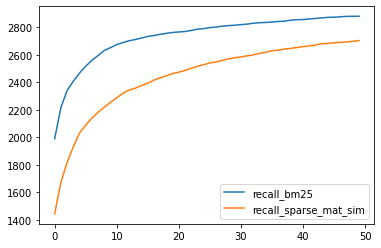

In [29]:
'''
    Recall count
'''
from matplotlib import pyplot as plt

for func in recall_func_list:
    func_name = func.__name__
    plt.plot(metric_stat[func_name], label=func_name)

plt.legend()
plt.show()

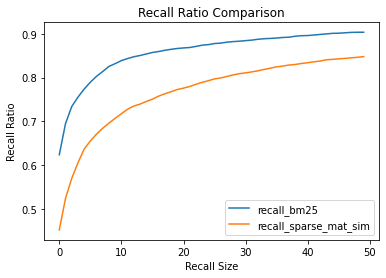

In [33]:
'''
    Recall ratio
'''
sum_doc = 3188
for func in recall_func_list:
    func_name = func.__name__
    plt.plot(np.array(metric_stat[func_name]) / sum_doc, label=func_name)

plt.ylabel('Recall Ratio')
plt.xlabel('Recall Size')
plt.title('Recall Ratio Comparison')
plt.legend()
plt.savefig('recall_ratio.png')
plt.show()

In [34]:
sum([1990, 226, 124, 68, 59, 50, 43, 35, 37, 20])/3188

0.8318695106649937

## Export Validation Recall Set

As **RECALL_SIZE**=500 by default, we export a data frame of all queries with 500 documents id.

In [35]:
'''
    Export test data frames
'''
RECALL_SIZE = 50
# RECALL_SIZE = 100

def export_query(input_pd):
    query_id_col = []
    doc_id_col = []

    # Recalling features used
    func_name = 'recall_bm25'
    for query in zip(input_pd['query_id'], input_pd[func_name]):
        query_id, recall_set = query
        recall_set = recall_set[:RECALL_SIZE]
        for doc_id in recall_set:
            query_id_col.extend([query_id])
            doc_id_col.extend([doc_id])

    export_pd = pd.DataFrame({'query_id': query_id_col, 'doc_id': doc_id_col})
    print(f'{len(export_pd)} items exported')
    return export_pd

export_file = csv_folder + f'validation_recalling_{RECALL_SIZE}.csv'
export_pd = export_query(query_pd)
export_pd['doc_id'] = export_pd['doc_id'].apply(int)
export_pd['query_id'] = export_pd['query_id'].apply(int)
export_pd.to_csv(export_file, index=False)

150000 items exported


## Generate Features for Recall Set

In [36]:
'''
    Interface for training dataset generation
    * Features computation
'''

def pool_extract(data, f, chunk_size, worker=8):
    from multiprocessing import cpu_count,Pool
    cpu_worker = cpu_count()
    print('CPU core:{}'.format(cpu_worker))
    if worker == -1 or worker > cpu_worker:
        worker = cpu_worker
    print('Cores used:{}'.format(worker))
    len_data = len(data)
    start = 0
    end = 0
    p = Pool(worker)
    res = []
    while end < len_data:
        end = start + chunk_size
        if end > len_data:
            end = len_data
        rslt = p.apply_async(f, args=(data[start:end],))
        start = end
        res.append(rslt)
    p.close()
    p.join()
    results = pd.concat([i.get() for i in res], axis=0, ignore_index=True)
    return results

def generate_features(export_file, feature_file, new_set=False):
    feature_pd = None
    if new_set:
        export_pd = pd.read_csv(export_file)
        feature_pd = export_pd[['doc_id', 'query_id']]
    else:
        feature_pd = pd.read_csv(feature_file)
    # feature_pd = get_features(feature_pd)
    feature_pd = pool_extract(feature_pd, get_features, CHUNK_SIZE, worker=8)
    feature_pd.to_csv(feature_file, index=False)

In [ ]:
RECALL_SIZE = 50
csv_folder = './data/csv/'
test_folder = './data/test/'
CHUNK_SIZE = RECALL_SIZE * len(query_pd) // 8
print(f'Chunk Size = {CHUNK_SIZE}')

export_file = csv_folder + f'validation_recalling_{RECALL_SIZE}.csv'
feature_file = test_folder + f'validation_recalling_{RECALL_SIZE}.csv'

generate_features(export_file, feature_file, new_set=True)

## Get Ranking Scores

In [4]:
import pandas as pd
RECALL_SIZE = 50
csv_folder = './data/csv/'
test_folder = './data/test/'
feature_file = test_folder + f'validation_recalling_{RECALL_SIZE}.csv'
feature_pd = pd.read_csv(feature_file)
test_pd = feature_pd[['query_id', 'doc_id']]

In [5]:
feat_name = pd.read_pickle('./model/XGB/50/single_model').get_booster().feature_names

In [6]:
validation_file = csv_folder + 'validation.csv'
validation_pd = pd.read_csv(validation_file)
validation_pd.to_csv(validation_file, index=False)
# validation_pd = validation_pd.sort_values('query_id')

## Eval Ranking

In [7]:
import numpy as np
eval_labels = np.zeros((len(validation_pd), 10))
idx = 0
for query in zip(validation_pd['query_id'], validation_pd['query_label']):
    query_id, query_label = query
    query_label = [int(i) for i in query_label.split()]
    query_label += [np.nan for _ in range(10-len(query_label))]
    eval_labels[idx] = np.array(query_label)
    idx += 1

In [8]:
def get_np_pred(metric='pred'):
    test_labels = np.zeros((len(validation_pd), 10))
    idx = 0
    for name, group in test_pd_group:
        group = group.sort_values(metric, ascending=False).head(10)
        query_label = group['doc_id'].values.tolist()
        test_labels[idx] = np.array(query_label)
        idx += 1
    return test_labels

def rank_pred(metric):
    rank_dict = dict()
    for name, group in test_pd.groupby('query_id'):
        group = group.sort_values(metric, ascending=False)
        for i in range(len(group)):
            rank_dict[group.iloc[0]['query_id']] = len(group) - i
    test_pd[metric] = test_pd['query_id'].apply(lambda x: rank_dict[x])

In [13]:
import warnings
warnings.filterwarnings('ignore')

lgb_single_pred = get_single_pred(feature_pd[feat_name], 50, 'LGB')
xgb_single_pred = get_single_pred(feature_pd[feat_name], 50, 'XGB')
cat_single_pred = get_single_pred(feature_pd[feat_name], 50, 'CAT')

test_pd['lgb_pred'] = lgb_single_pred / max(lgb_single_pred)
test_pd['xgb_pred'] = xgb_single_pred / max(xgb_single_pred)
test_pd['cat_pred'] = cat_single_pred / max(cat_single_pred)

'''
    Weight Scoring
'''
test_pd_group = test_pd.groupby('query_id', sort=False)

recall_pred_col = []
for name, group in test_pd_group:
    recall_pred_col += [(len(group) - i) / len(group) for i in range(len(group))]
test_pd['recall_pred'] = recall_pred_col

lgb_mrr = MRR(get_np_pred('lgb_pred'), eval_labels)
xgb_mrr = MRR(get_np_pred('xgb_pred'), eval_labels)
cat_mrr = MRR(get_np_pred('cat_pred'), eval_labels)
bm25_mrr = MRR(get_np_pred('recall_pred'), eval_labels)

print(lgb_mrr)
print(xgb_mrr)
print(cat_mrr)
print(bm25_mrr)

0.3824079365079368
0.428432275132275
0.37572037037037037
0.4211854497354499


In [14]:
test_pd

,query_id,doc_id,lgb_pred,xgb_pred,cat_pred,recall_pred
0,404021,2451807,0.999546,0.987537,0.914845,1.00
1,404021,583441,0.999546,0.992392,0.906713,0.98
2,404021,265855,0.999546,0.990219,0.915339,0.96
3,404021,5784331,0.999546,0.973772,0.904767,0.94
4,404021,6841132,0.999546,0.976786,0.909102,0.92
...,...,...,...,...,...,...
149995,733477,2179098,0.915886,0.547937,0.655948,0.10
149996,733477,1291089,0.915886,0.593837,0.685402,0.08
149997,733477,1517357,0.965091,0.582305,0.696489,0.06
149998,733477,3485818,0.915886,0.417827,0.553499,0.04


In [ ]:
s_ret = dict()
max_ret = 0
for a0 in range(0, 10):
    for a1 in range(0, 10 - a0 + 1):
        for a2 in range(0, 10 - a0 - a1 + 1):
            a3 = 10 - a0 - a1 - a2
            if a3 < 0:
                continue
            print(a0, a1, a2, a3)
            test_pd['pred'] = (a0 * test_pd['lgb_pred'] + a1 * test_pd['xgb_pred'] + a2 * test_pd['cat_pred'] + a3 * test_pd['recall_pred']) / 4
            pred_mrr = MRR(get_np_pred('pred'), eval_labels)
            s_ret[(a0, a1, a2, a3)] = pred_mrr
            max_ret = max(max_ret, pred_mrr)

In [43]:
def get_weighted_pred(a0, a1, a2, a3):
    test_pd['pred'] = (a0 * test_pd['lgb_pred'] + a1 * test_pd['xgb_pred'] + a2 * test_pd['cat_pred'] + a3 * test_pd['recall_pred'])
    pred_mrr = MRR(get_np_pred('pred'), eval_labels)
    return pred_mrr

print(get_weighted_pred(9, 1, 0, 0))

0.4308230158730158


In [42]:
test_pd

,query_id,doc_id,lgb_pred,xgb_pred,cat_pred,recall_pred,pred
0,404021,2451807,0.999546,0.987537,0.914845,1.00,2.495862
1,404021,583441,0.999546,0.992392,0.906713,0.98,2.497076
2,404021,265855,0.999546,0.990219,0.915339,0.96,2.496532
3,404021,5784331,0.999546,0.973772,0.904767,0.94,2.492421
4,404021,6841132,0.999546,0.976786,0.909102,0.92,2.493174
...,...,...,...,...,...,...,...
149995,733477,2179098,0.915886,0.547937,0.655948,0.10,2.197727
149996,733477,1291089,0.915886,0.593837,0.685402,0.08,2.209202
149997,733477,1517357,0.965091,0.582305,0.696489,0.06,2.317032
149998,733477,3485818,0.915886,0.417827,0.553499,0.04,2.165200
